# Tuning Sklearn Models with Ray

Using the Santander Dataset from: 
https://www.kaggle.com/c/santander-customer-transaction-prediction/
This dataset is about predicting customer transactions based on obfuscated features

In [12]:
import pandas as pd

In [13]:
#load train
train = pd.read_csv("data/train.csv")

In [14]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [15]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [16]:
subset_train = train.iloc[:, 1:30]
subset_train.shape

(200000, 29)

In [17]:
train_sample = subset_train.sample(n=20000)

## Quick EDA

quick eda on the dataset just to see if there is any particular "weirdness"

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
profile = train_sample.profile_report(
    html = {
        "inline": False
    }
)
profile.to_file("test_report.html")

Test Widgets

In [ ]:
profile.to_widgets()

In [ ]:
report = train_sample.profile_report()

## Feature Building

Feature Tools is best around hierarchial data and temporal data (import featuretools as ft)
Autofeat generates a lot of features, probably from looking at interactions between the 200 odd existing features that we have.... So it's overloading RAM 

In [8]:
from autofeat import FeatureSelector, AutoFeatClassifier

In [18]:
# extract out the target var from train
target = train['target']
ft_train = train.drop(['target', 'ID_code'], axis=1)
var_list = list(ft_train.columns)
#ft_train = ft_train.astype('float16')
#ft_train[var_list] = ft_train[var_list].apply(pd.to_)

In [ ]:
#afreg = AutoFeatClassifier(verbose=1, feateng_steps=2, max_gb=5, n_jobs=12)

# this is killing the kernel...
#ft_train_tr = afreg.fit_transform(ft_train, target)

[AutoFeat] The 2 step feature engineering process could generate up to 980700 features.
[AutoFeat] With 200000 data points this new feature matrix would use about 784.56 gb of space.
[AutoFeat] As you specified a limit of 5 gb, the number of data points is subsampled to 1274
[feateng] Step 1: transformation of original features
[feateng] Generated 918 transformed features from 200 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 623612 feature combinations from 624403 original feature tuples - done.
[feateng] Generated altogether 624531 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 350468 additional features


## Building Model

- simple baseline model first

# Standard Fit

Standard fit without any tuning

In [21]:
# preproc things
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
X_scale = StandardScaler().fit_transform(ft_train)
X_train, X_test, y_train, y_test = \
        train_test_split(X_scale, target, test_size=.4, random_state=42)

# Fit a Model

In [23]:
from sklearn import tree

In [24]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [25]:
score = clf.score(X_test, y_test)
score

0.836025

# Assess Model

baseline test

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
confusion_matrix(y_test, clf.predict(X_test))

array([[65183,  6715],
       [ 6403,  1699]])

In [31]:
class_names = ['no_transact', 'transact']

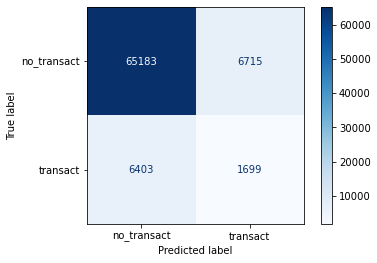

In [34]:
plot_confusion_matrix(clf, X_test, y_test,
                     display_labels=class_names,
                     cmap=plt.cm.Blues)

In [91]:
# TODO - get this working
from sklearn.metrics import auc, roc_curve

In [83]:
# Check Class Order
clf.classes_

array([0, 1])

In [80]:
y_pred = clf.predict_proba(X_test)

In [84]:
# Output in the classes_ order
y_pred[:,1]

array([0., 0., 0., ..., 0., 0., 1.])

In [77]:
pd.value_counts(y_test)

0    71898
1     8102
Name: target, dtype: int64

In [86]:
# checking for No Positive Samples Error
from collections import Counter
Counter(y_test)

Counter({0: 71898, 1: 8102})

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1], 
                                         pos_label=2)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [87]:
fpr

array([0.      , 0.105175, 1.      ])

In [69]:
auc(fpr, tpr)

nan

# Traditional Grid Search


In [35]:
from sklearn.model_selection import GridSearchCV

In [40]:
parameters = {'criterion': ('gini', 'entropy'), 
              'max_depth': [2, 6, 8] 
             }
gs_clf = tree.DecisionTreeClassifier()

In [44]:
gs_clf_searcher = GridSearchCV(gs_clf, parameters, n_jobs=8)

In [45]:
gs_clf_searcher.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 6, 8]})

In [48]:
gs_clf_searcher.best_params_

{'criterion': 'gini', 'max_depth': 2}

# Ray SKLearn test

In [49]:
from tune_sklearn import TuneGridSearchCV

In [59]:
import ray
ray.init(dashboard_host="0.0.0.0")

2020-12-01 13:20:28,620	INFO services.py:1090 -- View the Ray dashboard at http://172.17.0.3:8267


{'node_ip_address': '172.17.0.3',
 'raylet_ip_address': '172.17.0.3',
 'redis_address': '172.17.0.3:12411',
 'object_store_address': '/tmp/ray/session_2020-12-01_13-20-27_866905_3805/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-01_13-20-27_866905_3805/sockets/raylet',
 'webui_url': '172.17.0.3:8267',
 'session_dir': '/tmp/ray/session_2020-12-01_13-20-27_866905_3805',
 'metrics_export_port': 58220,
 'node_id': '37a23f1f64dc2072c379bfedcff99498aa8986f5'}

In [60]:
tune_search = TuneGridSearchCV(
    gs_clf,
    parameters,
    n_jobs=4
)

In [61]:
tune_search.fit(X_train, y_train)

2020-12-01 13:24:42,930	INFO tune.py:439 -- Total run time: 213.85 seconds (213.82 seconds for the tuning loop).


TuneGridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=4,
                 param_grid={'criterion': ('gini', 'entropy'),
                             'max_depth': [2, 6, 8]},
                 scoring={'score': <function _passthrough_scorer at 0x7fc93cf97550>})

In [62]:
tune_search.cv_results_

{'params': [{'criterion': 'gini', 'max_depth': 2},
  {'criterion': 'entropy', 'max_depth': 2},
  {'criterion': 'gini', 'max_depth': 6},
  {'criterion': 'entropy', 'max_depth': 6},
  {'criterion': 'gini', 'max_depth': 8},
  {'criterion': 'entropy', 'max_depth': 8}],
 'split0_test_score': array([0.90004167, 0.90004167, 0.89795833, 0.8985    , 0.89620833,
        0.89545833]),
 'split1_test_score': array([0.90004167, 0.90004167, 0.898     , 0.89804167, 0.89566667,
        0.89525   ]),
 'split2_test_score': array([0.90004167, 0.90004167, 0.89825   , 0.89829167, 0.89616667,
        0.89716667]),
 'split3_test_score': array([0.90004167, 0.90004167, 0.89904167, 0.89895833, 0.89779167,
        0.896     ]),
 'split4_test_score': array([0.9       , 0.9       , 0.89875   , 0.89929167, 0.89675   ,
        0.896625  ]),
 'mean_test_score': array([0.90003333, 0.90003333, 0.8984    , 0.89861667, 0.89651667,
        0.8961    ]),
 'std_test_score': array([1.66666667e-05, 1.66666667e-05, 4.27037599e-

In [58]:
#ray.shutdown()